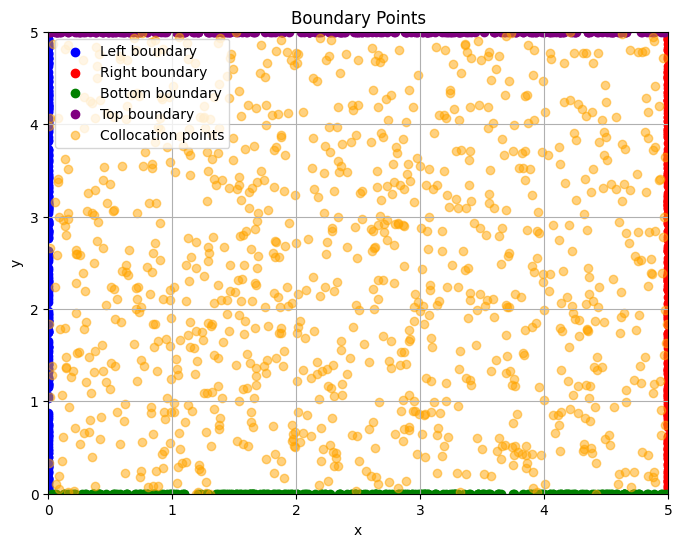

In [27]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Given parameters
delta_T = 50 # K
rb_star = 20e-6 # m
lc = rb_star
rb = rb_star / lc
A_star = 0.1
P_star = 210 # W
domain_size_star = 100e-6 # m
domain_size = domain_size_star / lc
T_s_star = 1878 # K
T_l_star = 1928 # K
rho__star = 3730 # kg/m^3
Cp_star = 830  # J/kgK
k_star = 33 # W/mK
alph_diff_star = k_star / (rho__star * Cp_star)
k_cap = 4.02
Lamda = 1.08e-6
alpha_star = 4 * np.pi * k_cap / Lamda
alpha_c = alpha_star
alpha = alpha_star / alpha_c

x_max_star = domain_size_star
x_max = x_max_star / lc

y_max_star = domain_size_star
y_max = y_max_star / lc

class PhysicsInformedNN(nn.Module):
    def __init__(self, layers, X_b, X_f, t):
        super(PhysicsInformedNN, self).__init__()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        for layer in self.linear[:-1]:
            x = torch.tanh(layer(x))
        x = self.linear[-1](x)
        return x
    
    def net_bc(self, x, y, t):
        X = torch.cat([x, y, t], 1)
        theta = self.forward(X)
        theta_x = torch.autograd.grad(theta, x, torch.ones_like(theta), create_graph=True)[0]
        theta_y = torch.autograd.grad(theta, y, torch.ones_like(theta), create_graph=True)[0]
        bc = theta_x + theta_y
        return bc
    
    
    
    def net_collocation(self, x, y, t):
        X = torch.cat([x, y, t], 1)
        theta = self.forward(X)
        
        theta_t = torch.autograd.grad(theta, t, torch.ones_like(theta), create_graph=True)[0]
        theta_x = torch.autograd.grad(theta, x, torch.ones_like(theta), create_graph=True)[0]
        theta_xx = torch.autograd.grad(theta_x, x, torch.ones_like(theta_x), create_graph=True)[0]
        theta_y = torch.autograd.grad(theta, y, torch.ones_like(theta), create_graph=True)[0]
        theta_yy = torch.autograd.grad(theta_y, y, torch.ones_like(theta_y), create_graph=True)[0]
        
        term1 = ((tau * 2 * A_star * P_star * alpha_c * alpha)/k_star*delta_T*np.pi*lc**2*rb**2)
        term2 = torch.exp(-2*(x**2 + (y - y_max)**2/rb**2))
        term3 = torch.exp(-alpha_c*alpha*lc*abs(y-y_max))
        Q_0 =  term1 * term2 * term3
        
        net_f = -(1/alph_diff_star)*theta_t + (tau/lc**2)*(theta_xx + theta_yy) + Q_0
        return net_f
    
    def train(self, epochs=10000):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        self.iter = 0
        self.losses = []
        self.loss = nn.MSELoss()
        
        self.bc_sol = np.zeros((X_b.shape[0], 1))
        self.collocation_sol = np.zeros((x_f.shape[0], 1))
        
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            bc_pred = self.net_bc(X_b[:, 0:1], X_b[:, 1:2], t)
            collocation_pred = self.net_collocation(X_f[:, 0:1], X_f[:, 1:2], t)
            
            bc_pred_loss = self.loss(bc_pred, self.bc_sol)
            collocation_pred_loss = self.loss(collocation_pred, self.collocation_sol)
    
            
            loss = bc_pred_loss + collocation_pred_loss
            loss.backward()
            self.optimizer.step()
            
            self.iter += 1
            self.losses.append(loss.item())
            
            if self.iter % 1000 == 0:
                print(f'Epoch {self.iter}/{epochs}, Loss: {loss} Boundary Loss: {bc_pred_loss} Collocation Loss: {collocation_pred_loss}')
        self.plot_losses()
        
        def predict(self, x, y,t):
            self.eval()
            with torch.no_grad():
                X = torch.cat([x, y, t], 1)
                theta = self.forward(X)
            return theta.numpy()
        
    
    def plot_losses(self):
        plt.plot(self.losses)
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss vs Epochs')
        plt.grid(True)
        plt.show()
            
    
    
if __name__ == "__main__":
    N_theta = 1000
    N_time = 10
    N_F = 1000 
    
    # Left boundary
    x_left_star = np.zeros((N_theta//4, 1), dtype=float)
    y_left_star = np.random.uniform(0, domain_size_star, (N_theta//4, 1))
    x_left = x_left_star / lc
    y_left = y_left_star / lc
    
    # Right boundary
    x_right_star = np.full((N_theta//4, 1), domain_size_star, dtype=float)
    y_right_star = np.random.uniform(0, domain_size_star, (N_theta//4, 1))
    x_right = x_right_star / lc
    y_right = y_right_star / lc
    
    # Bottom boundary
    x_bottom_star = np.random.uniform(0, domain_size_star, (N_theta//4, 1))
    y_bottom_star = np.zeros((N_theta//4, 1), dtype=float)
    x_bottom = x_bottom_star / lc
    y_bottom = y_bottom_star / lc

    # Top boundary
    x_top_star = np.random.uniform(0, domain_size_star, (N_theta//4, 1))
    y_top_star = np.full((N_theta//4, 1), domain_size_star, dtype=float)
    x_top = x_top_star / lc
    y_top = y_top_star / lc

    # collocation points
    x_f_star = np.random.uniform(0, domain_size_star, (N_F, 1))
    y_f_star = np.random.uniform(0, domain_size_star, (N_F, 1))
    x_f = x_f_star / lc
    y_f = y_f_star / lc
    
    # stacking the datapoints for training
    '''
    time points:
    '''
    tau = 5e-6
    t_star_max = 5e-6
    t_star = np.linspace(0, t_star_max, N_time, dtype=float)
    t = t_star / tau

    
    '''
    boundary points:
    '''
    x_b = np.vstack((x_left, x_right, x_bottom, x_top))    
    y_b = np.vstack((y_left, y_right, y_bottom, y_top))
    X_b = np.hstack((x_b, y_b))
    
    '''
    collocation points:
    '''
    x_f = x_f.reshape(-1, 1)
    y_f = y_f.reshape(-1, 1)
    t = t.reshape(-1, 1)
    X_f = np.hstack((x_f, y_f))
    
    # Plot the points with different colors for each boundary
    plt.figure(figsize=(8, 6))
    plt.scatter(x_left, y_left, c='blue', label='Left boundary')
    plt.scatter(x_right, y_right, c='red', label='Right boundary')
    plt.scatter(x_bottom, y_bottom, c='green', label='Bottom boundary')
    plt.scatter(x_top, y_top, c='purple', label='Top boundary')
    plt.scatter(x_f, y_f, c='orange', label='Collocation points', alpha=0.5)
    plt.xlim(0, domain_size)
    plt.ylim(0, domain_size)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Boundary Points')
    plt.legend()
    plt.grid(True)
    plt.show()


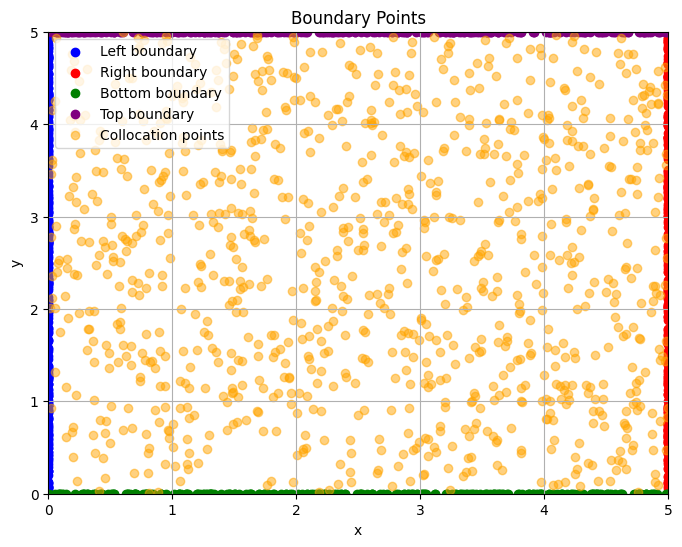

RuntimeError: you can only change requires_grad flags of leaf variables.